In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns

In [1]:
def pretty_scalings(lda, X, out=False):
    ret = pd.DataFrame(lda.scalings_, index=X.columns, columns=["LD"+str(i+1) for i in range(lda.scalings_.shape[1])])
    if out:
        print("Coefficients of linear discriminants:")
        print(ret)
    return ret

In [2]:
def calclda(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the discriminant function
    ld = np.zeros(numsamples)
    # calculate the value of the discriminant function for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        ld[i] = valuei
    # standardise the discriminant function so that its mean value is 0:
    ld = scale(ld, with_std=False)
    return ld

In [3]:
def groupStandardise(variables, groupvariable):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # find the variable names
    variablenames = variables.columns
    # calculate the group-standardised version of each variable
    variables_new = pd.DataFrame()
    for i in range(numvariables):
        variable_name = variablenames[i]
        variablei = variables[variable_name]
        variablei_Vw = calcWithinGroupsVariance(variablei, groupvariable)
        variablei_mean = np.mean(variablei)
        variablei_new = (variablei - variablei_mean)/(np.sqrt(variablei_Vw))
        variables_new[variable_name] = variablei_new
    return variables_new

In [4]:
def calcWithinGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the standard deviation for group i:
        sdi = np.std(levelidata)
        numi = (levelilength)*sdi**2
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the within-groups variance
    Vw = numtotal / (denomtotal - numlevels)
    return Vw

In [5]:
def rpredict(lda, X, y, out=False):
    ret = {"class": lda.predict(X),
           "posterior": pd.DataFrame(lda.predict_proba(X), columns=lda.classes_)}
    ret["x"] = pd.DataFrame(lda.fit_transform(X, y))
    ret["x"].columns = ["LD"+str(i+1) for i in range(ret["x"].shape[1])]
    if out:
        print("class")
        print(ret["class"])
        print()
        print("posterior")
        print(ret["posterior"])
        print()
        print("x")
        print(ret["x"])
    return ret

In [6]:
def ldahist(data, g, sep=False):
    xmin = np.trunc(np.min(data)) - 1
    xmax = np.trunc(np.max(data)) + 1
    ncol = len(set(g))
    binwidth = 0.5
    bins=np.arange(xmin, xmax + binwidth, binwidth)
    if sep:
        fig, axl = plt.subplots(ncol, 1, sharey=True, sharex=True)
    else:
        fig, axl = plt.subplots(1, 1, sharey=True, sharex=True)
        axl = [axl]*ncol
    for ax, (group, gdata) in zip(axl, data.groupby(g)):
        sns.distplot(gdata.values, bins, ax=ax, label="group "+str(group))
        ax.set_xlim([xmin, xmax])
        if sep:
            ax.set_xlabel("group"+str(group))
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [9]:
data = pd.read_csv("https://query.data.world/s/pefevj3ooghwq5a5ozibz2a3bbpfmo")
data.columns = ["V"+str(i) for i in range(1, len(data.columns)+1)]  # rename column names to be similar to R naming convention
del data['V2']
print(data)

    V1     V3     V4     V5    V6    V7     V8    V9
0    A  27.82  21.43  44.87  5.11  1.77   0.77  4.93
1    A  28.49  21.26  43.89  5.34  1.79   1.02  4.84
2    A  28.35  19.99  45.78  5.08  1.63   0.80  4.95
3    A  30.55  20.15  43.13  4.79  1.61   1.38  4.74
4    A  30.49  21.28  41.65  4.82  1.64   1.76  4.67
..  ..    ...    ...    ...   ...   ...    ...   ...
295  J  44.91  11.07  17.00  2.49  0.66  25.36  2.91
296  J  43.15  11.79  18.46  2.43  0.67  24.17  3.10
297  J  44.55  11.01  16.03  2.43  0.64  25.98  2.92
298  J  47.60  10.43  15.18  2.32  0.56  24.47  2.76
299  J  46.84   9.91  15.50  2.27  0.57  25.48  2.81

[300 rows x 8 columns]


In [12]:
X = data.loc[:,"V3":] # independent variables data
y = data.V1 # dependent variable data
standardisedX = scale(X)
lda = LinearDiscriminantAnalysis().fit(X, y)

In [13]:
pretty_scalings_ = pretty_scalings(lda, X, out=True)

Coefficients of linear discriminants:
         LD1       LD2        LD3       LD4        LD5        LD6        LD7
V3 -0.663233  1.156220  -0.345403  0.232812  -3.146559   0.665018  13.914167
V4 -1.024804  0.145452   0.591979 -0.271276  -4.036918  -1.611374  13.134106
V5 -0.139418  0.467230  -0.165454  0.099409  -4.420173  -4.706219  12.330973
V6 -0.795743  0.960665   2.344665  5.604894  -2.497416   0.363425  14.112765
V7 -4.634889 -7.907822 -15.201018 -8.158391  -8.249621   3.240842  -2.146574
V8  0.124490  0.508836  -0.000523  0.274304  -3.877740  -1.669559  13.174369
V9 -3.323067  1.627844   0.165141  1.499994  17.498887  58.334822  18.342984


In [14]:
lda.scalings_[:, 0]

array([-0.66323319, -1.02480408, -0.13941821, -0.7957433 , -4.63488937,
        0.12448957, -3.32306711])

In [15]:
print(calclda(X, lda.scalings_[:, 0]))

[-18.35003742 -18.42907744 -16.74267357 -16.9027856  -17.6976795
 -17.31549229 -17.31450579 -17.57043021 -17.27308204 -17.7089111
 -17.35901084 -17.17248107 -16.26029047 -16.49117214 -17.47724021
 -16.0585756  -17.50960523 -15.77852915 -17.29849079 -16.4264651
 -15.98062132 -16.55619297 -17.47708395 -16.44549703 -16.45366041
 -16.8739879  -16.59114482 -15.64140081 -18.06834463 -12.63579448
 -12.93336707 -11.30996081 -12.31858186 -11.72317333 -12.24169485
 -12.49440727 -10.67721152 -11.6655317  -13.02717578 -12.6813911
 -12.13735909 -13.40660528 -11.94297481 -12.90322307 -13.14203481
 -12.57736307 -12.00244388 -12.59129847 -13.20114976 -11.75280814
 -11.96457812 -11.54236739 -13.10566222 -13.16052612 -12.96019875
 -12.82640415 -13.45592926 -13.35584007 -11.43653476 -11.59488582
 -19.84057498 -20.82555371 -18.66724755 -19.08394419 -18.31490485
 -18.99158493 -20.9476679  -20.73827807 -18.75102063 -20.57880891
 -20.0054527  -18.32126995 -20.21373452 -19.01719101 -18.16682038
 -17.20042073 

In [16]:
lda_values = rpredict(lda, standardisedX, y, True)

class
['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G'
 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 

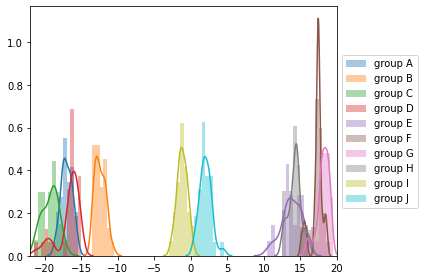

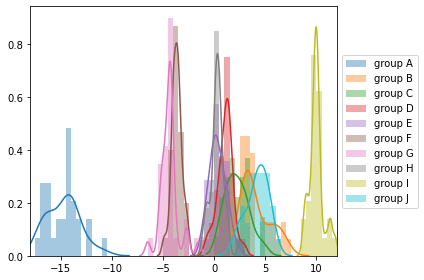

In [18]:
ldahist(lda_values["x"].LD1, y)
ldahist(lda_values["x"].LD2, y)

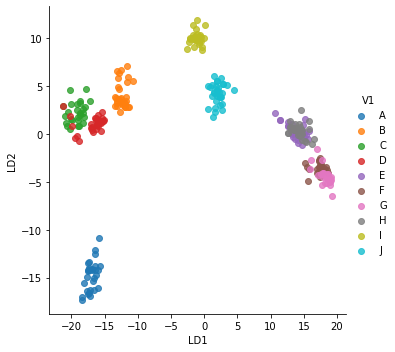

In [19]:
sns.lmplot("LD1", "LD2", lda_values["x"].join(y), hue="V1", fit_reg=False);